# Introduction to AVO

Trying to reproduce some figures in Blangy, JP, 1994, AVO in tranversely isotropic media—An overview. *Geophysics* **59** (5), 775–781. This is a good starting point, because Blangy defined some rocks very fully and clearly, and provides an anisotropic AVO approximation. So, even if we don't look at his equation in particular, it's a good starting point.

Related blog post: [The Blangy equation](http://www.agilegeoscience.com/blog/2014/8/7/the-blangy-equation.html?rq=blangy)

The usual prelims:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll also load Blangy's test data, from his Table 1:

In [2]:
type1 = {'shale':      {'vp':3300., 'vs':1700., 'rho':2350., 'd':0.15, 'e':0.30}, 
         'sand_gas':   {'vp':4200., 'vs':2700., 'rho':2350., 'd':0.00, 'e':0.00},
         'sand_water': {'vp':4200., 'vs':2100., 'rho':2450., 'd':0.00, 'e':0.00},
         }
type2 = {'shale':      {'vp':2896., 'vs':1402., 'rho':2250., 'd':0.15, 'e':0.30},
         'sand_gas':   {'vp':3322., 'vs':2215., 'rho':2000., 'd':0.00, 'e':0.00},
         'sand_water': {'vp':3322., 'vs':1402., 'rho':2250., 'd':0.00, 'e':0.00},
         }
type3 = {'shale':      {'vp':2307., 'vs':1108., 'rho':2150., 'd':0.15, 'e':0.30}, 
         'sand_gas':   {'vp':1951., 'vs':1301., 'rho':1950., 'd':0.00, 'e':0.00},
         'sand_water': {'vp':1951., 'vs': 930., 'rho':2200., 'd':0.00, 'e':0.00},
         }

We'll start with a wet sand case, Type 2. This just defines the rock types we'll need.

In [3]:
# Upper layer
vp1 = type2['shale']['vp']
vs1 = type2['shale']['vs']
rho1 = type2['shale']['rho']

# Lower layer
vp0 = type2['sand_water']['vp']
vs0 = type2['sand_water']['vs']
rho0 = type2['sand_water']['rho']

# Angle range
theta1 = np.arange(0, 45, 1)

## Linear Shuey equation

Let's start with a bit of maths — [the 2-term Shuey approximation](http://subsurfwiki.org/wiki/Shuey_equation). I'm using the formulation given by Avesth, P, T Mukerji and G Mavko (2005). *Quantitative seismic interpretation.* Cambridge University Press, Cambridge, UK. 

$$R(\theta) \approx R(0) + G \sin^2 \theta$$

where

$$R(0) = \frac{1}{2} \left( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right)$$

and

$$G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right)$$

In these equations, $\Delta V_\mathrm{P}$ means the difference in the velocity of the two layers, and $V_\mathrm{P}$ means the mean of the two layers. Let's make a function to help with this 'difference over mean':

In [4]:
def dom(upper, lower):
    return np.subtract(lower, upper) / np.mean((lower, upper))

First term:

In [5]:
R0 = 0.5 * (dom(vp1, vp0) + dom(rho1, rho0))

Second term, in two parts:

In [6]:
G_1 = 0.5 * dom(vp1, vp0)
G_2 = 2 * (np.mean((vs0, vs1))**2 / np.mean((vp0, vp1))**2) * (dom(rho1, rho0) + 2 * dom(vs1, vs0))
G = G_1 - G_2

Put it all together with the angle term, remembering radians:

In [7]:
shuey = R0 + G * np.sin(np.radians(theta1))**2

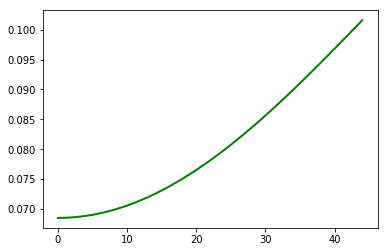

In [8]:
plt.plot(shuey, 'g', lw=2)
plt.show()

## Compare to Zoeppritz

Let's avoid a lot of algebra and use [our library Bruges](https://github.com/agile-geoscience/bruges) for our equations, so we don't have to define everything from scratch.

In [9]:
import bruges

In [10]:
zoe = bruges.reflection.zoeppritz_rpp(vp1, vs1, rho1,
                                      vp0, vs0, rho0,
                                      theta1)

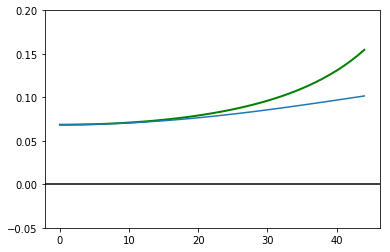

In [11]:
plt.plot(zoe, 'g', lw=2)
plt.plot(shuey)
plt.ylim(-0.05, 0.2)
plt.axhline(0, color='k')
plt.show()

### Q. Try some of the other rocks in Blangy's dataset. What happens if you make a gas reservoir?

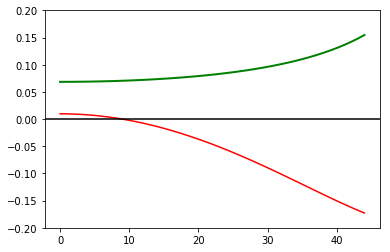

In [12]:
# Upper layer
vp1 = type2['shale']['vp']
vs1 = type2['shale']['vs']
rho1 = type2['shale']['rho']

# Lower layer
vp0 = type2['sand_gas']['vp']
vs0 = type2['sand_gas']['vs']
rho0 = type2['sand_gas']['rho']

zoe_gas = bruges.reflection.zoeppritz_rpp(vp1, vs1, rho1,
                                          vp0, vs0, rho0,
                                          theta1)

plt.plot(zoe, 'g', lw=2)
plt.plot(zoe_gas, 'r')
plt.ylim(-0.2, 0.2)
plt.axhline(0, color='k')
plt.show()

### Q. Try some other approximations in the `bruges.reflection` module.

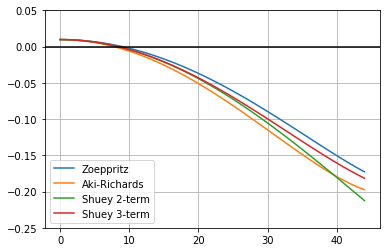

In [13]:
ar_gas = bruges.reflection.akirichards(vp1, vs1, rho1,
                                        vp0, vs0, rho0,
                                        theta1)

s2_gas = bruges.reflection.shuey2(vp1, vs1, rho1,
                                  vp0, vs0, rho0,
                                  theta1)

s3_gas = bruges.reflection.shuey3(vp1, vs1, rho1,
                                  vp0, vs0, rho0,
                                  theta1)

plt.plot(zoe_gas, label='Zoeppritz')
plt.plot(ar_gas, label='Aki-Richards')
plt.plot(s2_gas, label='Shuey 2-term')
plt.plot(s3_gas, label='Shuey 3-term')
plt.legend()
plt.ylim(-0.25, 0.05)
plt.axhline(0, color='k')
plt.grid()
plt.show()

### Q. Can you put the reflection coefficient on a time series and use the convolutional model to make a gather?

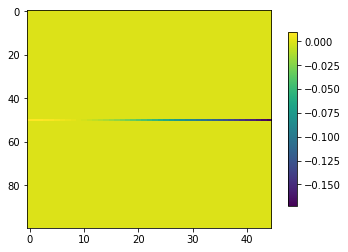

In [14]:
rc = np.zeros((100, theta1.size))
rc[50,:] = zoe_gas

plt.imshow(rc, aspect=0.4)
plt.colorbar(shrink=0.8)
plt.show()

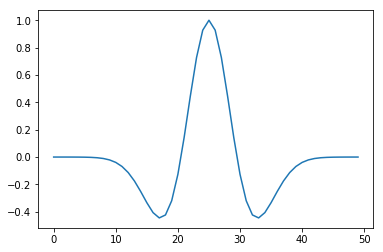

In [15]:
w = bruges.filters.ricker(duration=0.05, dt=0.001, f=50)

plt.plot(w); plt.show()

In [16]:
syn = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), arr=rc, axis=0)

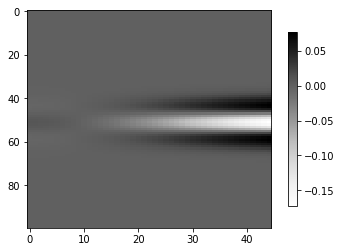

In [17]:
plt.imshow(syn, cmap='Greys', aspect=0.4)
plt.colorbar(shrink=0.8)
plt.show()

Notice how, if we formed a stacked volume from, say, 25 degrees of offset, the response would be completely different from the zero-offset response:

I'll plot them vertically to be consistent with the other figure:

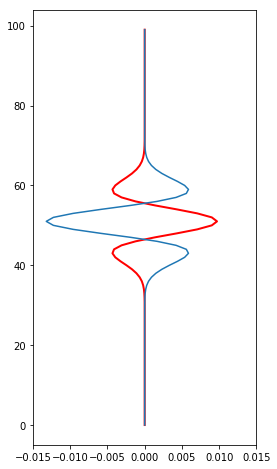

In [18]:
y = np.arange(100)
plt.figure(figsize=(4, 8))
plt.plot(syn[:, 0], y, 'r', lw=2)  # Zero offset
plt.plot(np.mean(syn[:, 0:25], axis=1), y)
plt.xlim(-0.015, 0.015)
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>